# Quora Insincere Questions Classification

- https://www.kaggle.com/c/quora-insincere-questions-classification
- Insincere questions 분류해내기

## Index
1. Introduction
    - 1.1. General Description
    - 1.2. Original train set
    - 1.3. Test set
1. Modeling Result
    - 2.1. result
    - 2.2. Kaggle submission
1. Exploratory Data Analysis
    - 3.1 `target`
    - 3.2. Word frequency
    - 3.3. Meta feature
1. Pre-processing
1. Modeling
1. Conclusion & Review
    - 6.1. Unresolved problem

# 1. Introduction

In [1]:
from IPython.display import Image


## 1-1 General Description
---

- <h3>QUORA</h3>
<br>
     지식을 가진 사람들과 그 지식을 필요로 하는 사람들을 연결하는 목적으로 시작된 미국의 Q&A플랫폼으로, 실리콘 밸리 스타트업들의 운영 및 수익모델에 관련된 질문들에 그 회사의 투자자들이나 운영진이 답을 달기 시작한게 초창기였고, 이런 모범 사례를 시작으로 <b>진정성있는 질문들과 대답</b>이 오가는 커뮤니티로 사용자들에게 인정받아 급격히 성장한 회사이다. 

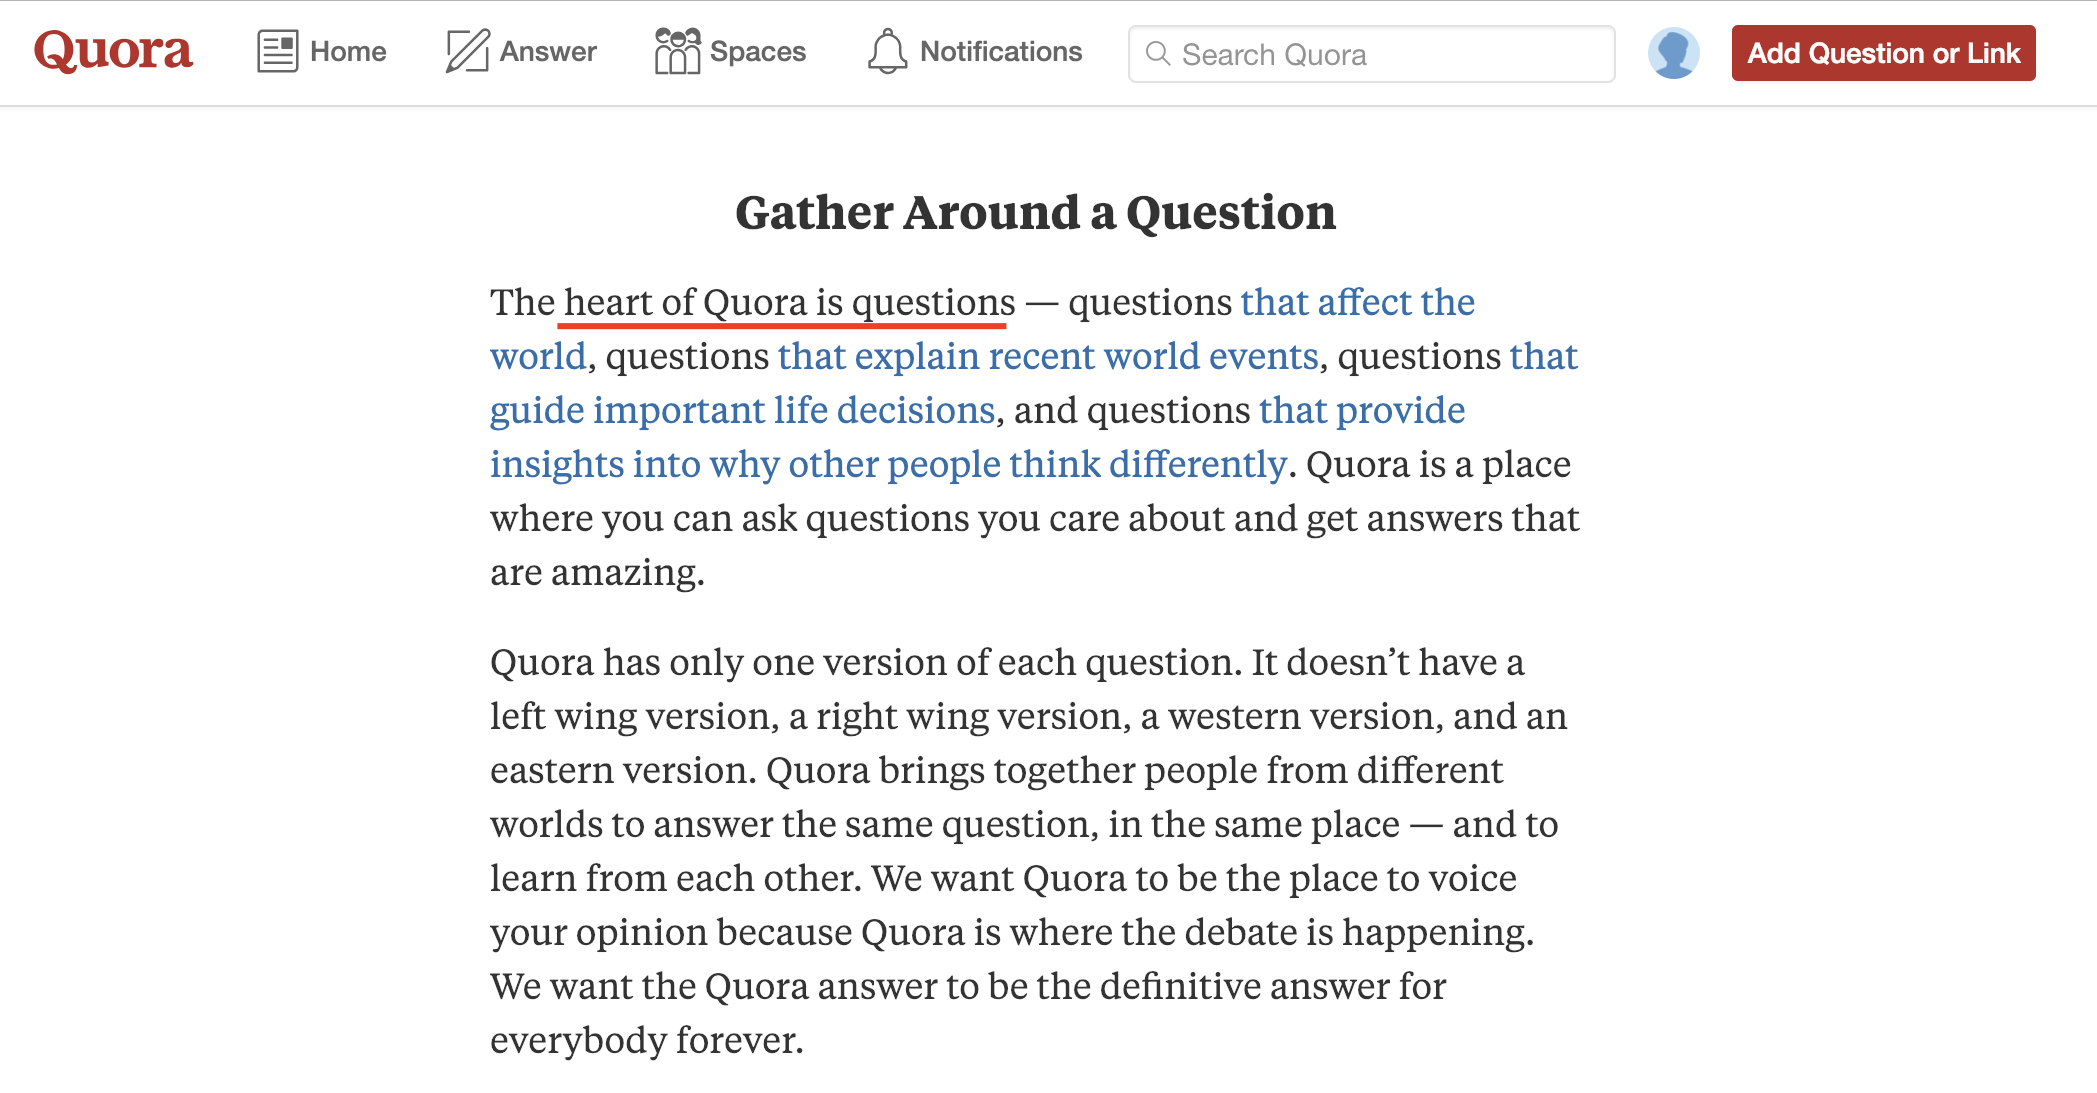

In [2]:
Image(filename = "./img/quora_question.png", width=800, height=800)

- 대회의 목적 :  In this competition you will be predicting whether a question asked on Quora is sincere or not. 

---
- <h3>Insincere Questions</h3>
<br>
    An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

    - Has a <b><u>non-neutral</u></b> tone
        - Has an exaggerated tone to underscore a point about a group of people
        - Is rhetorical and meant to imply a statement about a group of people
    - Is disparaging or inflammatory
        - Suggests a <b><u>discriminatory</u></b> idea against a protected class of people, or seeks confirmation of a stereotype
        - Makes disparaging <b><u>attacks/insults</u></b> against a specific person or group of people
        - Based on an outlandish premise about a group of people
        - Disparages against a characteristic that is not fixable and not measurable
    - Isn't grounded in reality
        - Based on <b><u>false information</u></b>, or contains absurd assumptions
    - Uses <b><u>sexual content</u></b> (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers
---

## 1-2 Original train set

- 1306122 rows × 3 columns
- columns:
    - qid: 각 질문당 고유의 ID
    - question_text: 질문 문장 text data
    - target: 0 or 1 (sincere or insincere)

In [3]:
original_train_set = pd.read_csv("train.csv")
original_train_set.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

## 1-3 Test set
- for kaggle submission
- 56370 rows × 2 columns

In [4]:
test_set = pd.read_csv("test_quora.csv")
test_set.tail()

qid                                      question_text
56365  fffcf200619ef3426fc5  Would I owe Queen Elizabeth II, if I could som...
56366  fffd424460c17be3f503        Is 6740 a good rank in Manipal online test?
56367  fffe18f21e5e070e55de  What would you like DC to do to make their mov...
56368  fffe4dd6bb7fd8fc1924  Do you think our system is fair? Consider fact...
56369  fffed08be2626f74b139  Why do all the stupid people I know tend to be...

## Import

In [5]:
pd.options.display.max_rows = 100
pd.set_option('display.max_colwidth', -1)

In [66]:
from sklearn.model_selection import train_test_split
from langdetect import detect_langs, detect
from collections import defaultdict
import enchant
from tqdm import tqdm
from multiprocessing import Pool
import string
import copy

import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, accuracy_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold


import plotly.plotly as py
import plotly.graph_objs as go

tqdm.pandas()

# 2. Modeling result
- 최종 모델: 
    - tokenizer = `CountVectorizer`
    - model = `LogisticRegression()`

## 2.1 Result
- <b>Tokenizer</b> : CountVectorizer 
- <b>Model</b> = LogisticRegression(class_weight='balanced')
- trained on original text where special characters and numbers were removed.

In [7]:
# 전처리가 완료된 데이터를 가지고 있는 csv file을 읽어온다.
train_set = pd.read_csv("./train_final.csv")

In [8]:
dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(train_set.remove_string_special, train_set.target, test_size=0.2, random_state=5)

vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = 'english')
vectorizer.fit(train_set.remove_string_special)
xtrain_vectorized =  vectorizer.transform(dfX_train)
xtest_vectorized = vectorizer.transform(dfX_test)

model = LogisticRegression(C=1.0, class_weight='balanced').fit(X=xtrain_vectorized, y=dfy_train)
predictions = model.predict(xtest_vectorized)
print(classification_report(dfy_test, predictions, target_names=['class0', 'class1']))


              precision    recall  f1-score   support

      class0       0.98      0.96      0.97    244950
      class1       0.55      0.69      0.61     16248

   micro avg       0.95      0.95      0.95    261198
   macro avg       0.76      0.83      0.79    261198
weighted avg       0.95      0.95      0.95    261198



- cross-validation  
    - f1-score : [0.60708734, 0.60493142, 0.60912147, 0.60753098, 0.60602362]

## 2.2 kaggle submission
- Evaluation standard: F1 score
- 정밀도(Precision)과 재현율(Recall)의 가중 조화 평균

$$
F_1 = 2 \cdot \text{precision} \cdot \text{recall} \, / \, (\text{precision} + \text{recall})
$$

### Submission result

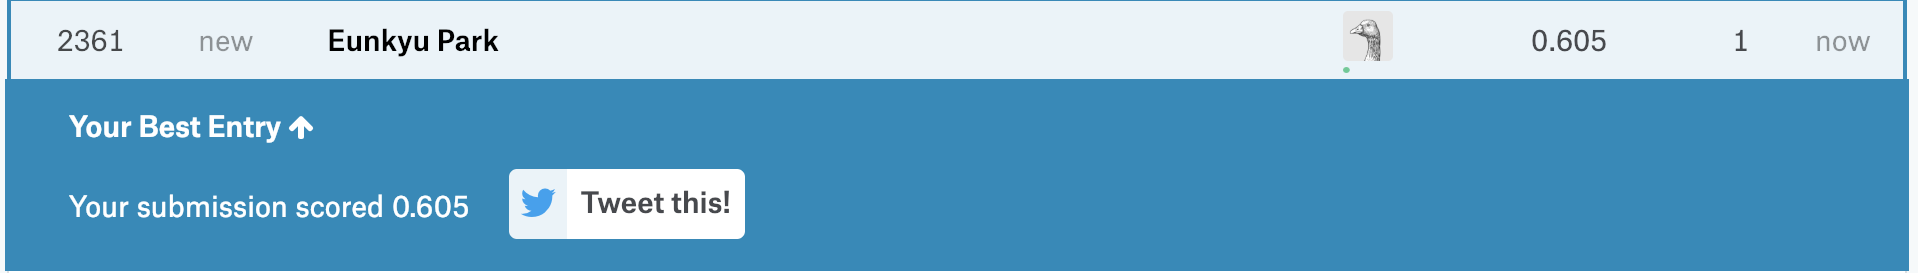

In [43]:
Image(filename = "./img/kaggle_submission.png", width=800, height=800)

---

# 3. Exploratory Data Analysis

## 3.1 `Target`
- Target 0: 1,225,312(93.81%)
- Target 1: 80,810(6.19%)

In [9]:
original_train_set.target.value_counts()

0    1225312
1    80810  
Name: target, dtype: int64

### Imbalanced data problem

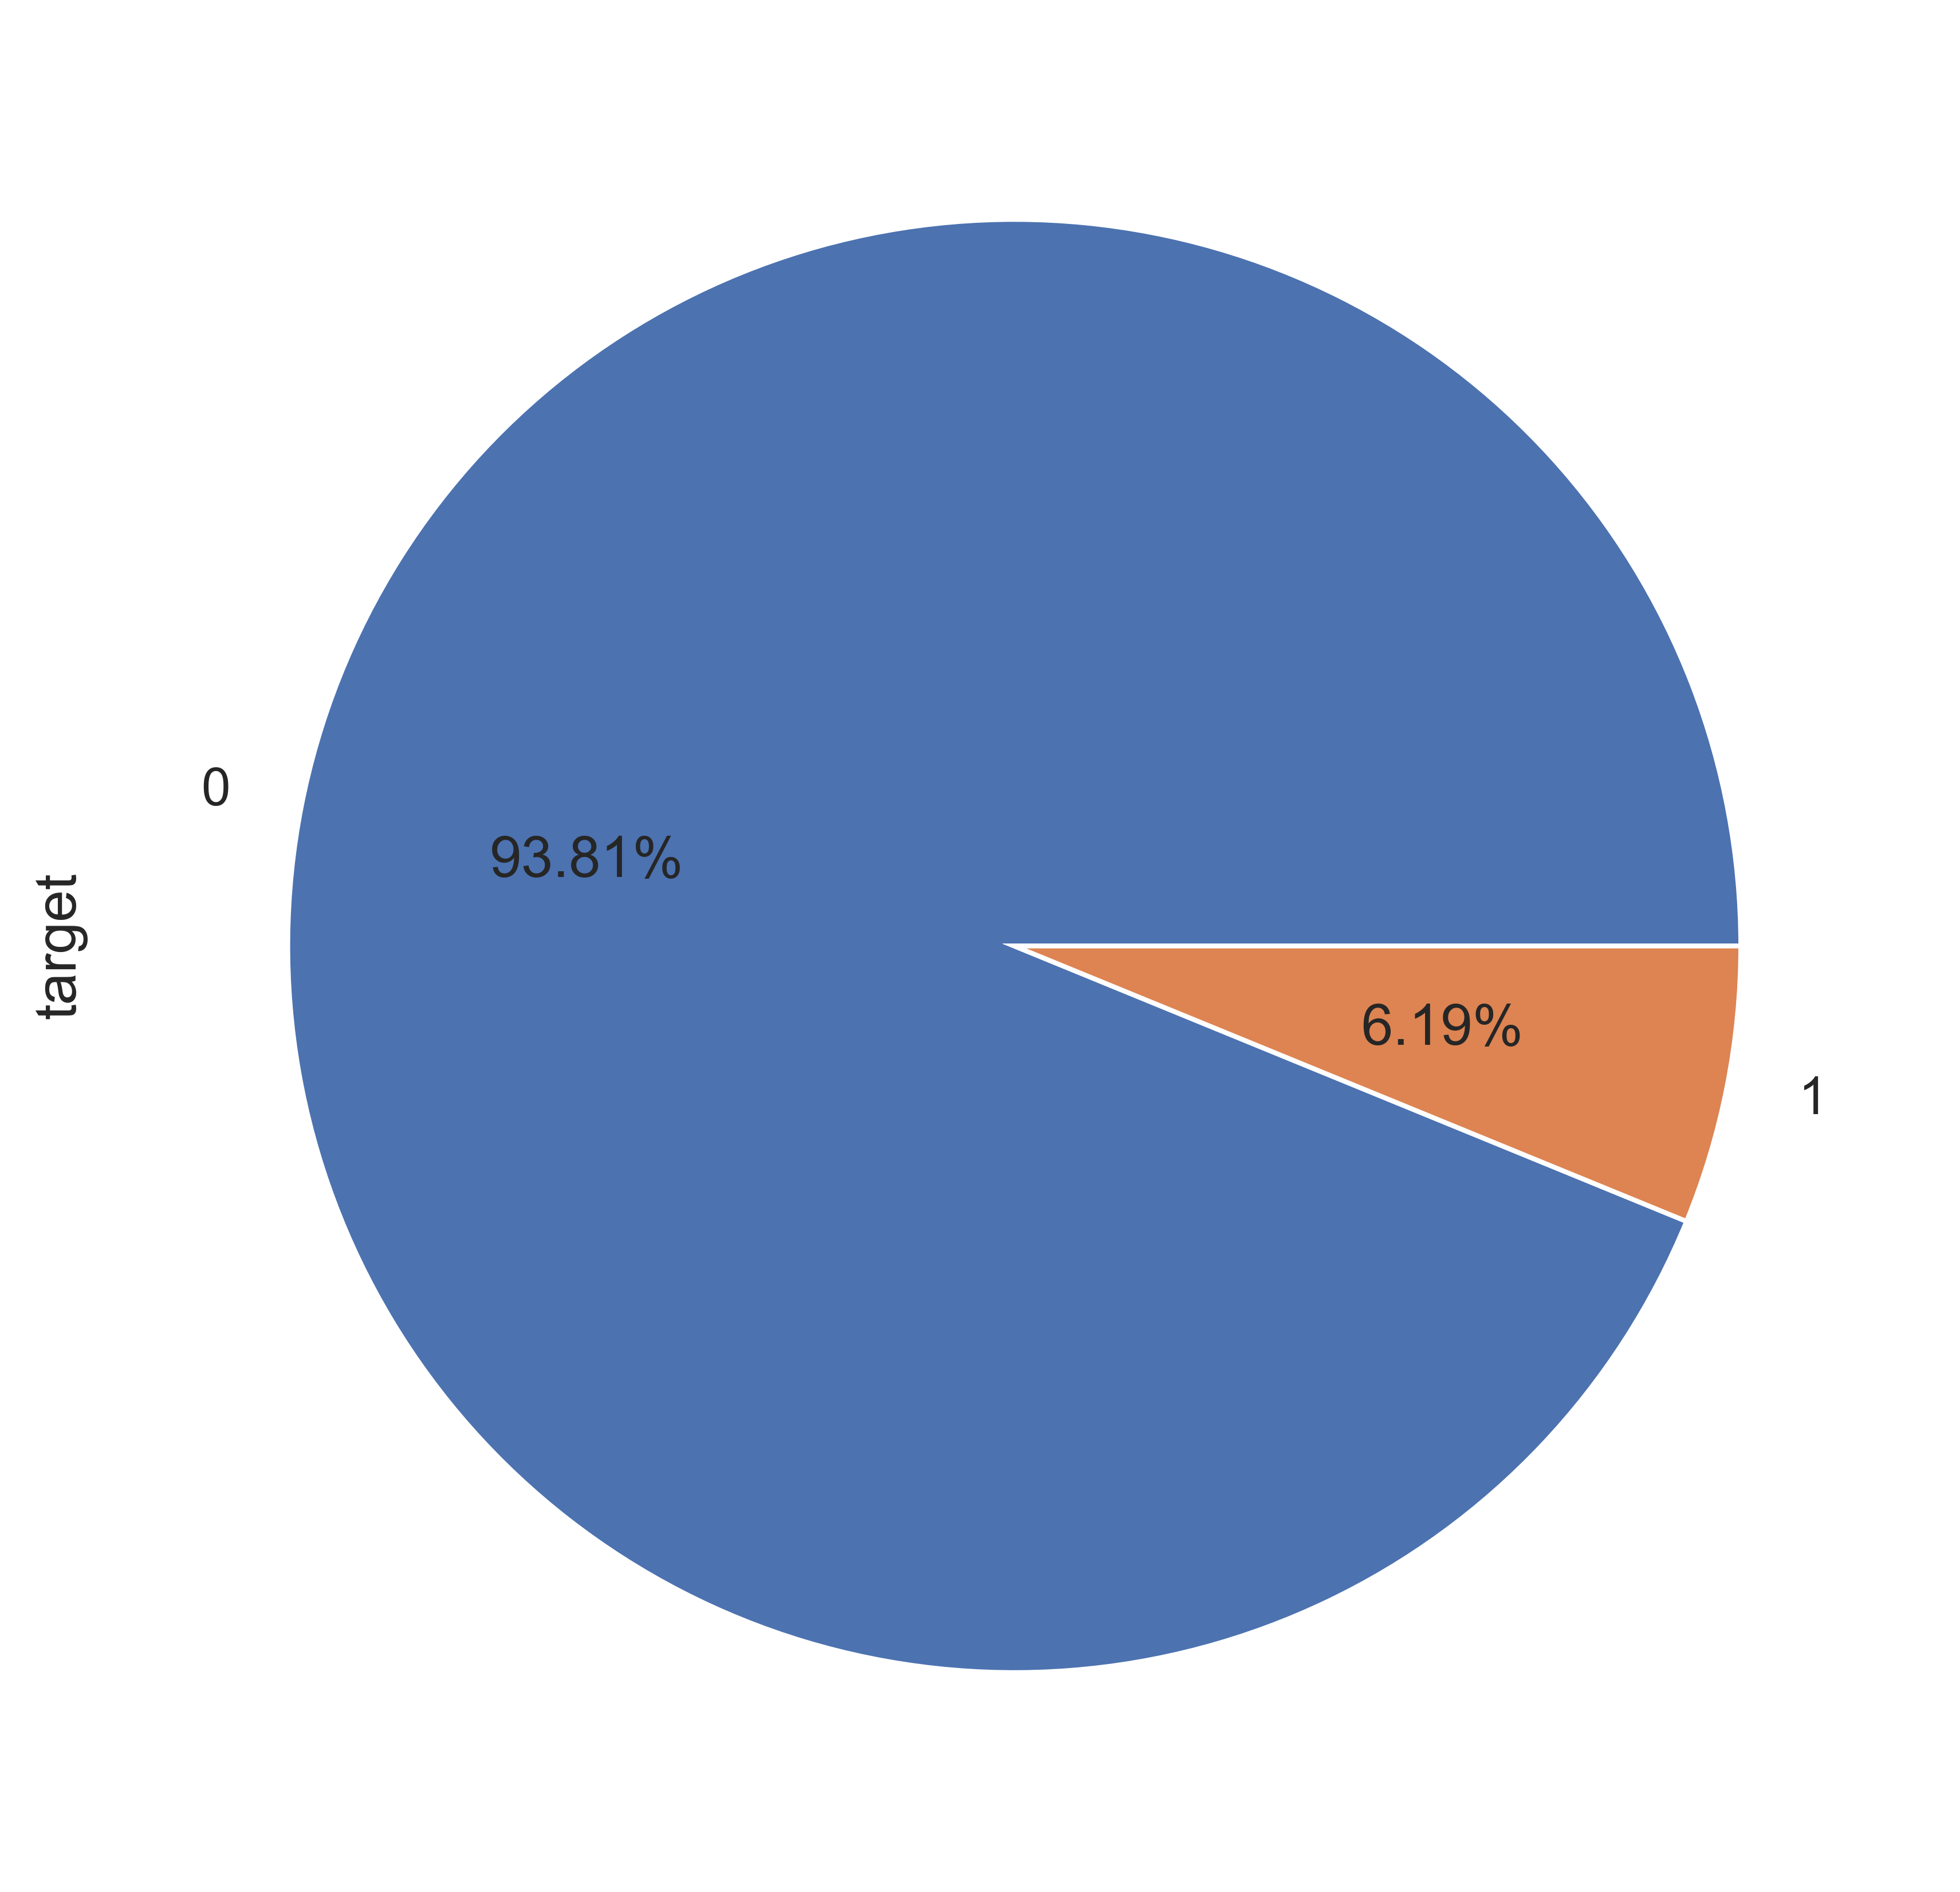

In [42]:
plt.rcParams['figure.figsize'] = (7,7)

original_train_set.target.value_counts().plot.pie(autopct='%.2f%%')
plt.show()

>Accuracy 보다는 F1 score에 초점을 두어야 할 필요성

## 3.2. Word frequency
- target 1에서 자주 등장하는 단어들에 대한 분석
- insincere words

In [12]:
def target_ngram_plot(target, n):
    df = train_set[train_set.target == target]

    frequencies = defaultdict(int)
    stop_list = stopwords.words('english')
    
    for sent in df["lemmatized"]:
        sent = str(sent)
        tokens = word_tokenize(sent)
        tokens = [token.lower() for token in tokens]
        tokens = [token for token in tokens if token.isalpha() if token != "" if token not in stop_list]

        for word in list(ngrams(tokens, n)):
            frequencies[word] += 1
    
    ngram_df = pd.DataFrame(sorted(frequencies.items(), key=lambda x: x[1], reverse=True))
    ngram_df.columns = ["word", "wordcount"]
    ngram_df = ngram_df[:20]

    sns.set(style="whitegrid")

    f, ax = plt.subplots(figsize=(6, 15))

    sns.set_color_codes("pastel")
    sns.barplot(x="wordcount", y="word", data=ngram_df,
                label="Total", color="b")

### target 1에서 가장 자주 등장하는 단어(1-gram)

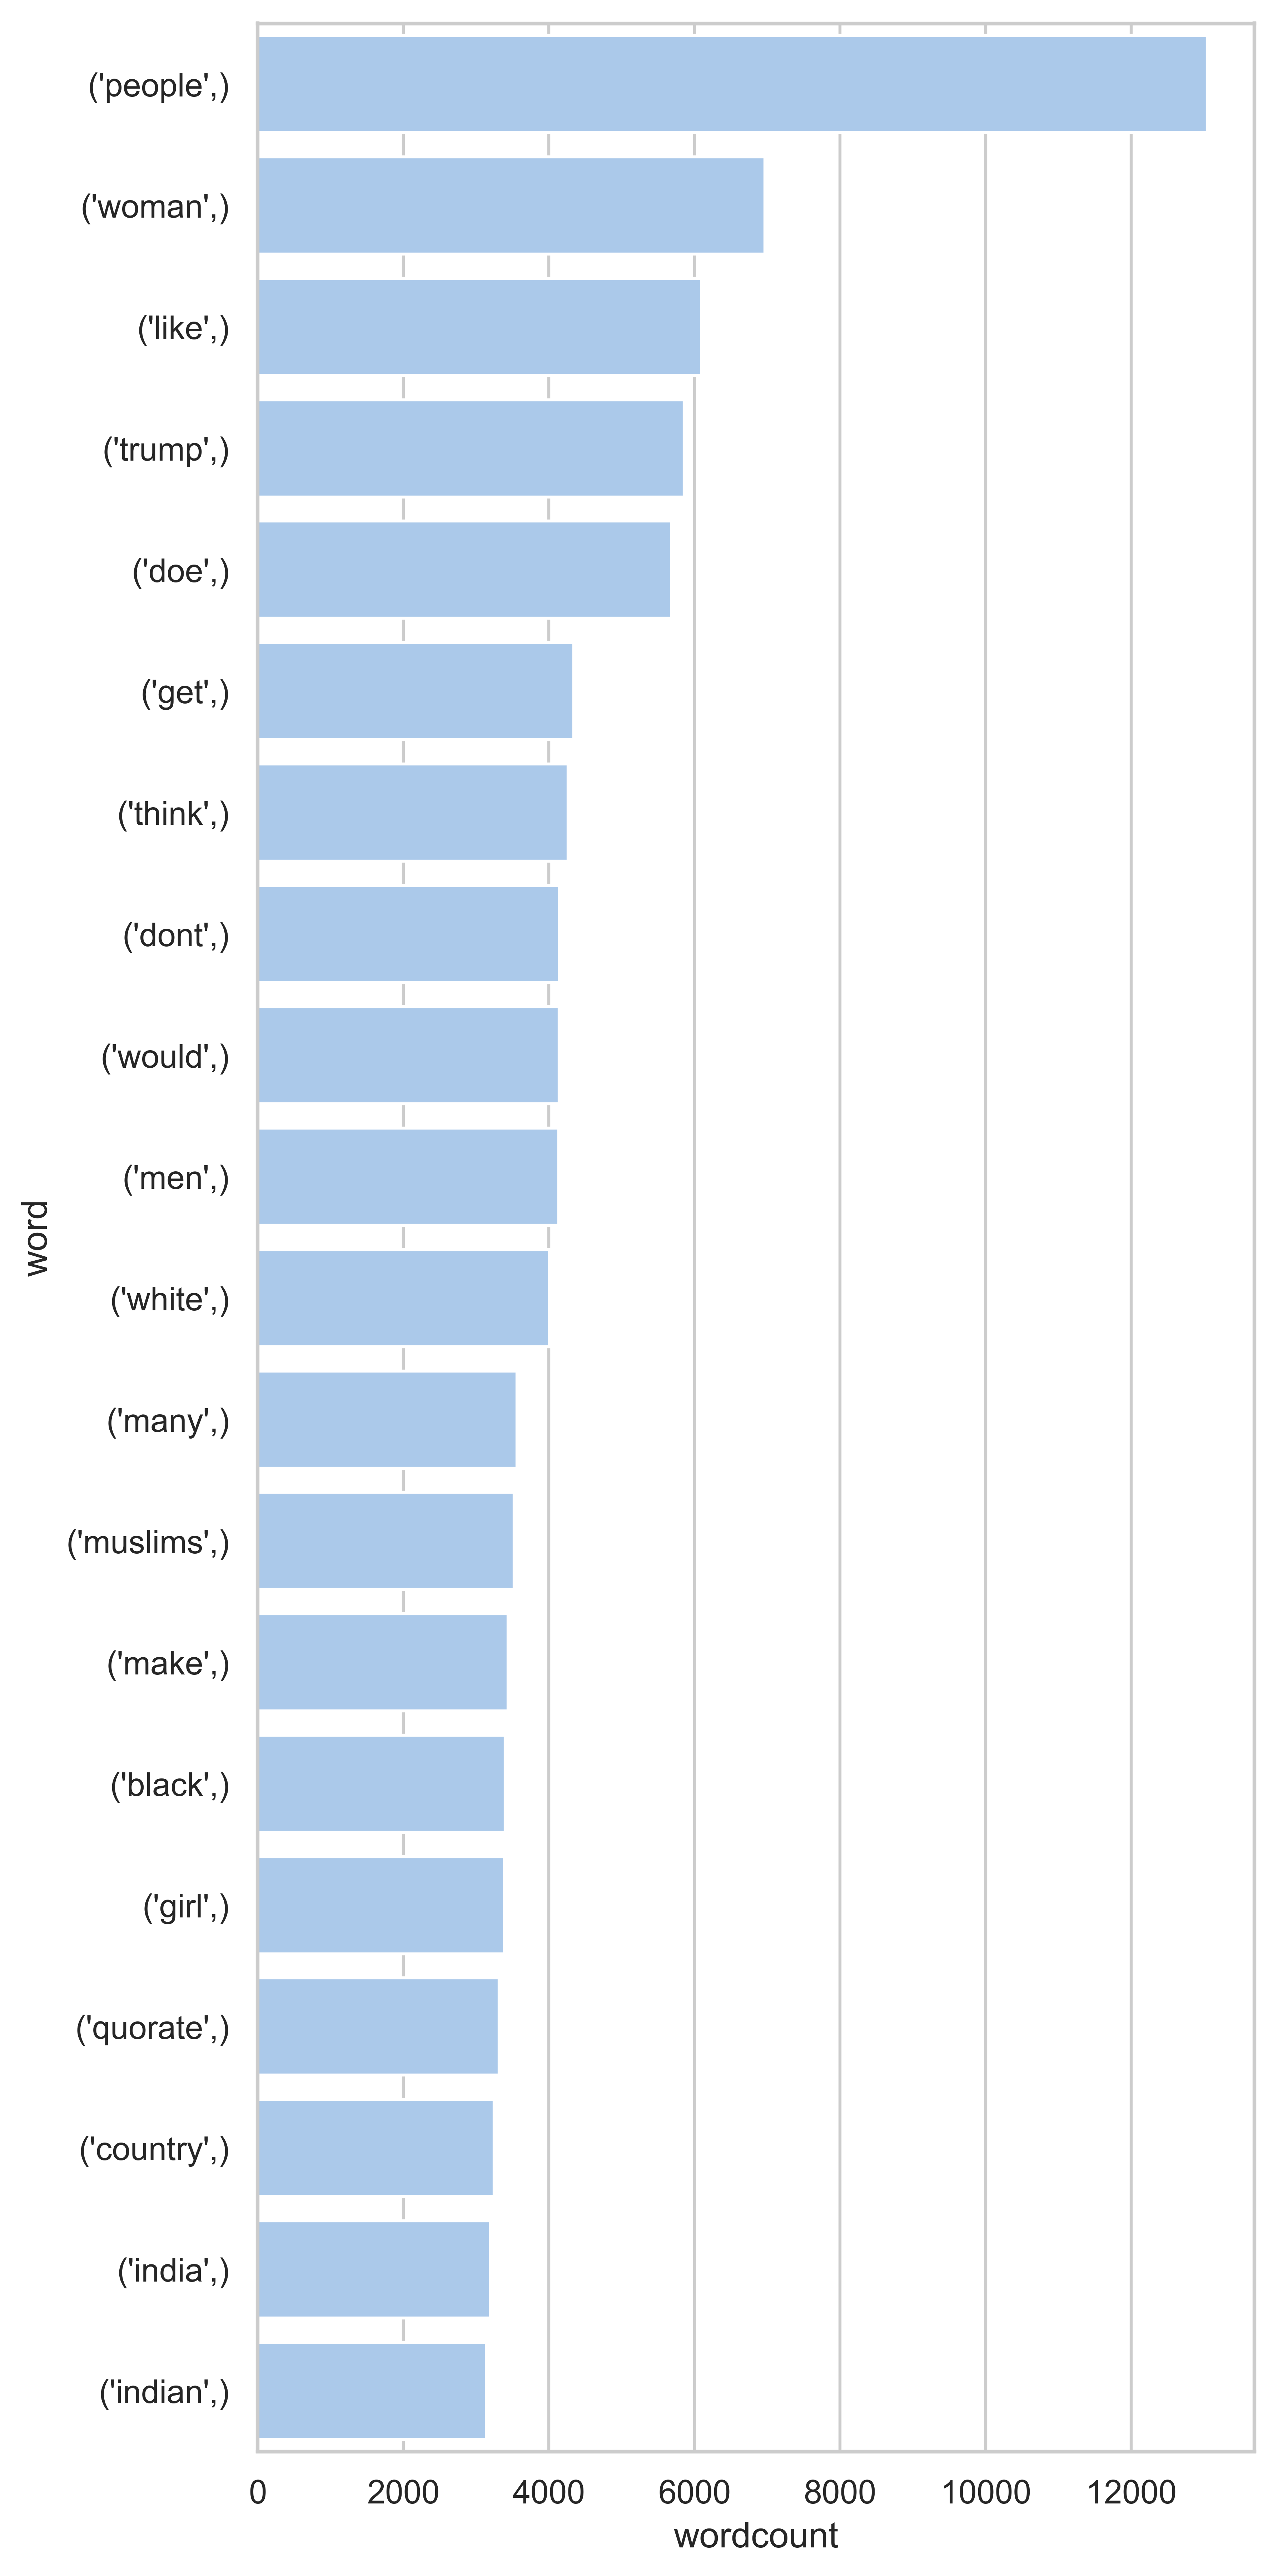

In [13]:
target_ngram_plot(1, 1)

### target 1에서 가장 자주 등장하는 단어(bigram)

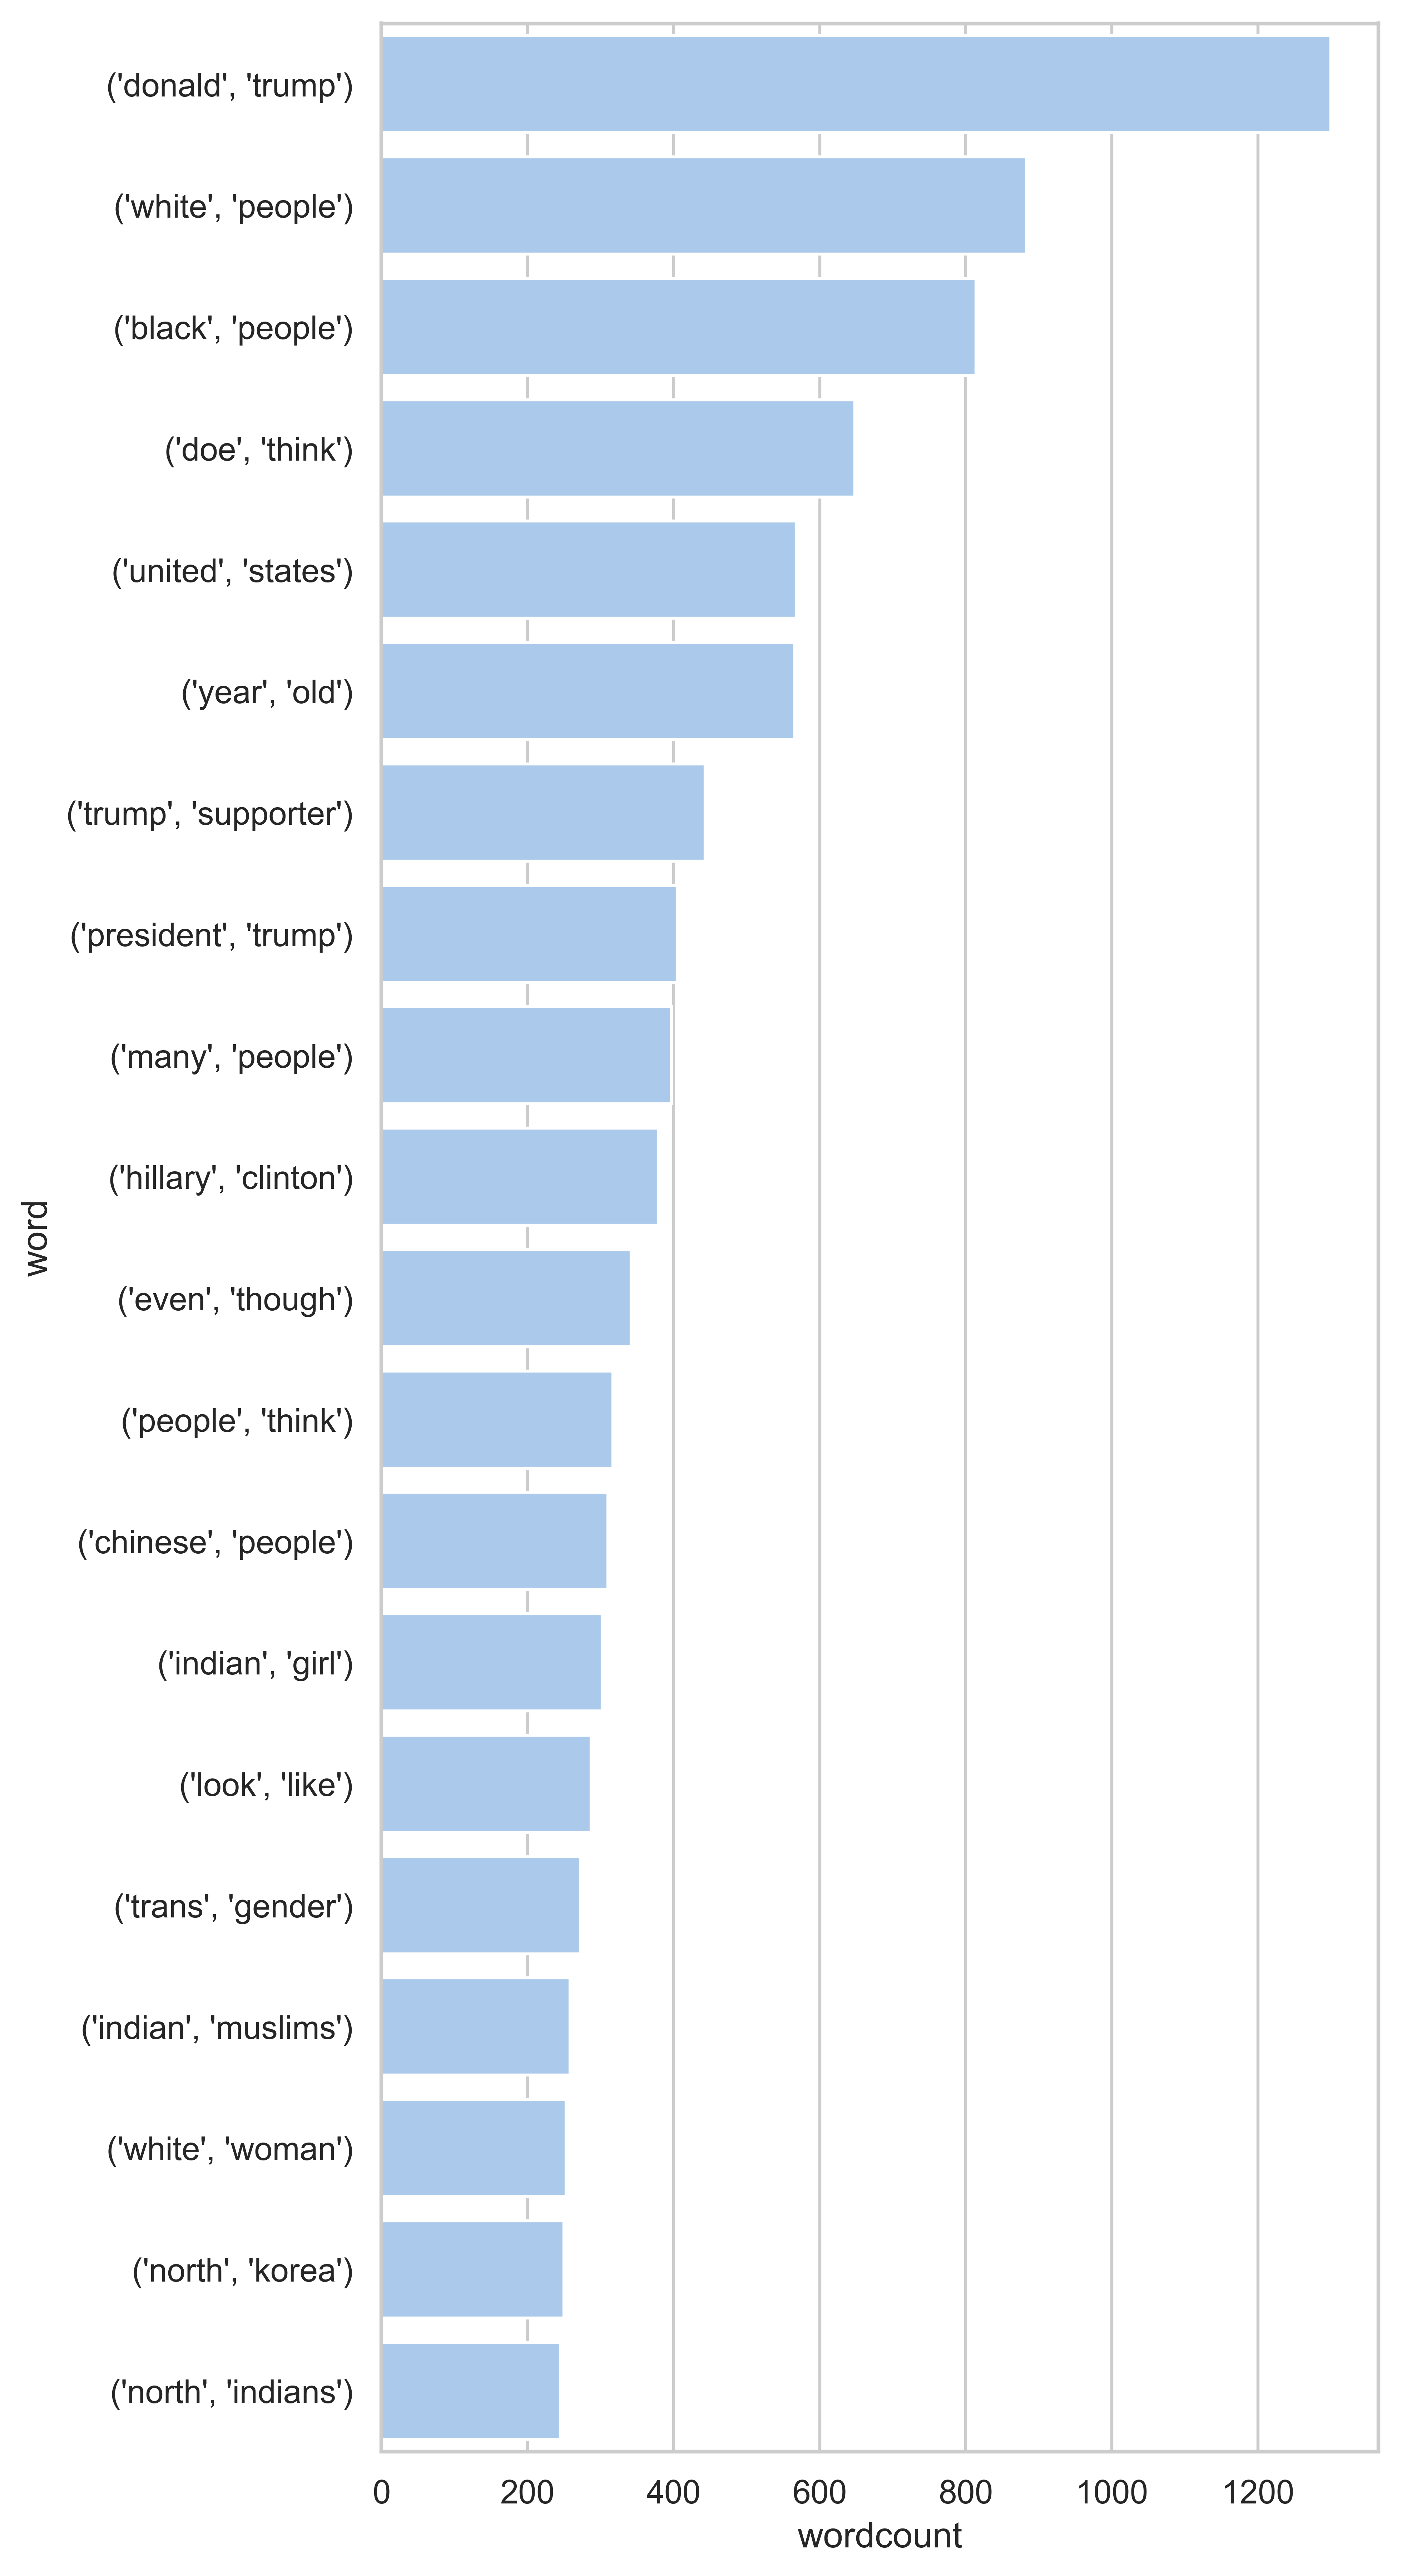

In [14]:
target_ngram_plot(1, 2)

### target 1에서 가장 자주 등장하는 단어(3-gram)

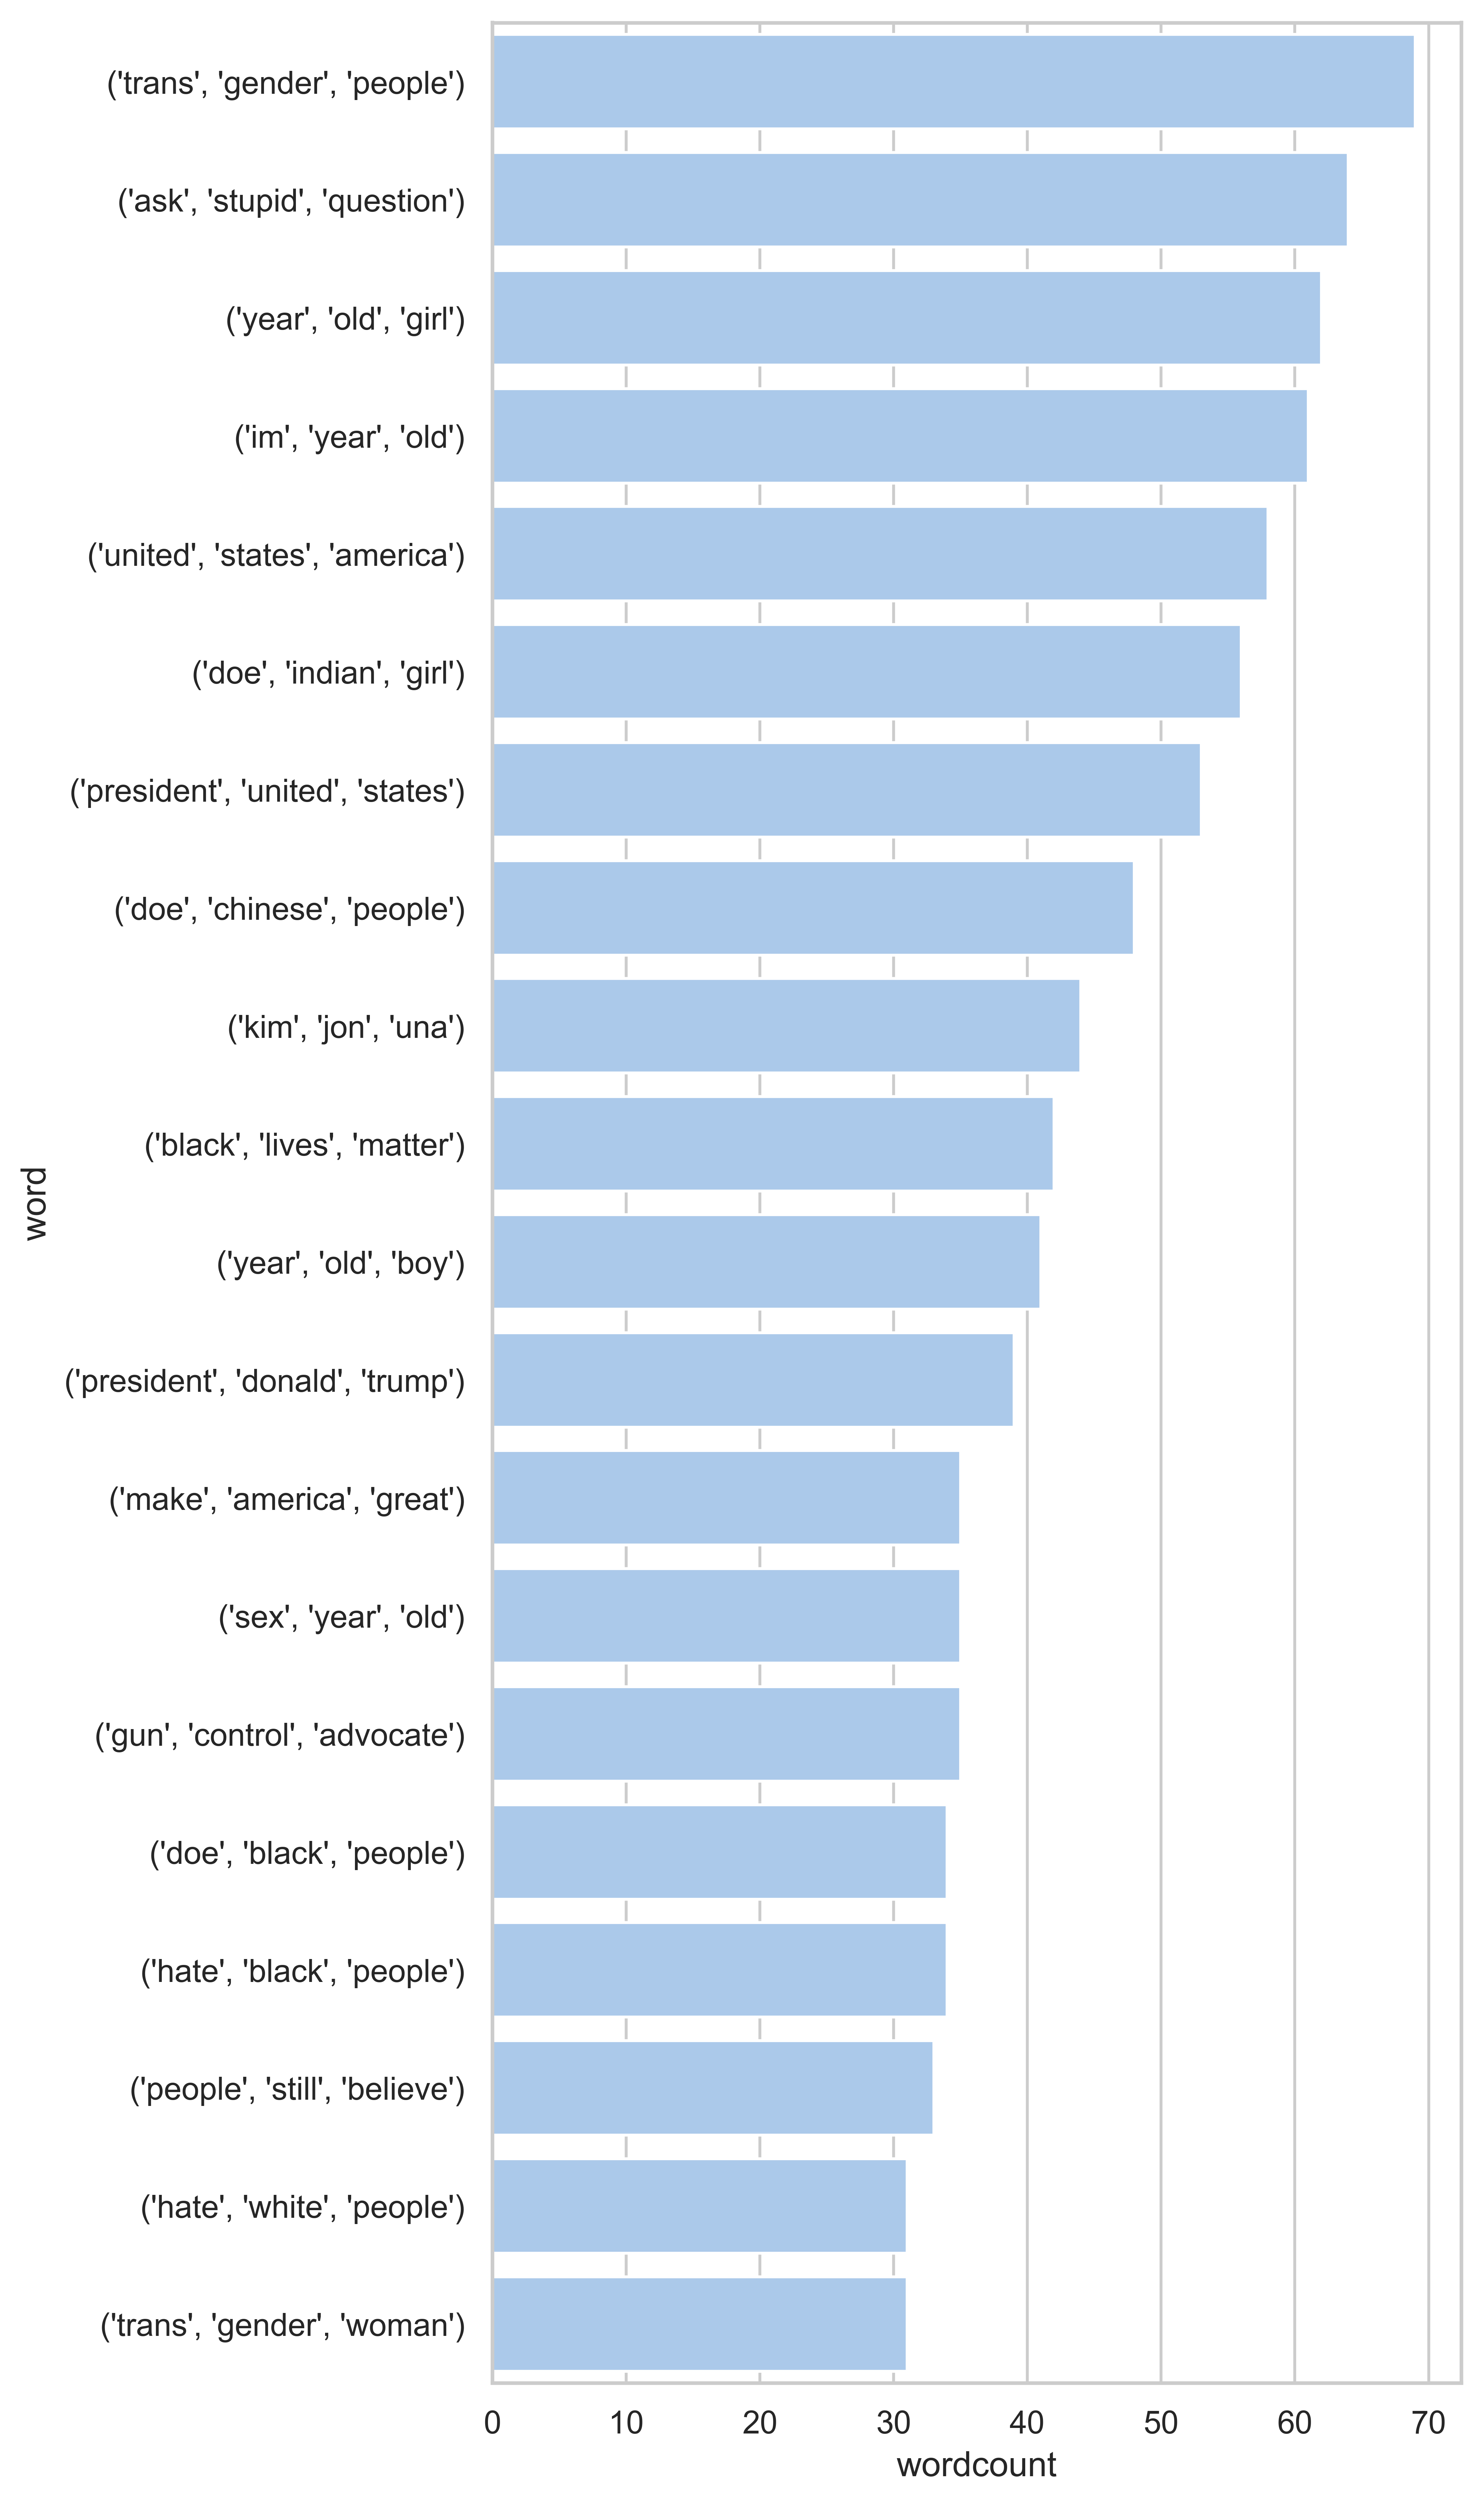

In [15]:
target_ngram_plot(1, 3)

## 3.3. Meta-features
- Number of words in the text
- Number of unique words in the text
- Number of characters in the text
- Number of stopwords
- Number of punctuations
- Number of upper case words

In [16]:
df_meta = copy.deepcopy(original_train_set)

In [17]:
from nltk.corpus import stopwords
import string
stopWords = set(stopwords.words('english'))

>소문자들로만 구성되어 있음

In [18]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Extract Meta feature

#### 1. Number of words in the text

In [19]:
df_meta["num_words"] = df_meta["question_text"].apply(lambda x: len(str(x).split()))

#### 2. Number of unique words in the text

In [20]:
df_meta["num_unique_words"] = df_meta["question_text"].apply(lambda x: len(set(str(x).split())))

#### 3. Number of characters in the text

In [21]:
df_meta["num_chars"] = df_meta["question_text"].apply(lambda x: len(str(x)))

#### 4. Number of stopwords in the text

In [22]:
df_meta["num_stopwords"] = df_meta["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopWords]))

#### 5. Number of punctuations in the text

In [23]:
df_meta["num_punctuations"] = df_meta['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#### 6. Number of upper words in the text

In [24]:
df_meta["num_words_upper"] = df_meta["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

### result

In [25]:
df_meta.tail()

qid  \
1306117  ffffcc4e2331aaf1e41e   
1306118  ffffd431801e5a2f4861   
1306119  ffffd48fb36b63db010c   
1306120  ffffec519fa37cf60c78   
1306121  ffffed09fedb5088744a   

                                                                                         question_text  \
1306117  What other technical skills do you need as a computer science undergrad other than c and c++?   
1306118  Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?     
1306119  Is foam insulation toxic?                                                                       
1306120  How can one start a research project based on biochemistry at UG level?                         
1306121  Who wins in a battle between a Wolverine and a Puma?                                            

         target  num_words  num_unique_words  num_chars  num_stopwords  \
1306117  0       17         16                93         9               
1306118  0       19         18                91         9               
1306119  0       4          4                 25         1               
1306120  0       13         13                71         5               
1306121  0       11         9                 52         7               

         num_punctuations  num_words_upper  
1306117  3                 0                
1306118  1                 4                
1306119  1                 0                
1306120  1                 1                
1306121  1                 0

## Visualization

>효과적인 시각화를 위하여 수치들을 일부분 조정합니다.

In [26]:
df_meta["num_words"].loc[df_meta["num_words"] > 60] = 60
df_meta["num_unique_words"].loc[df_meta["num_unique_words"] > 60] = 60
df_meta["num_chars"].loc[df_meta["num_chars"] > 400] = 400
df_meta["num_stopwords"].loc[df_meta["num_stopwords"] > 40] = 40
df_meta["num_punctuations"].loc[df_meta["num_punctuations"] > 20] = 20

In [27]:
# plt.rcParams['figure.figsize'] = (16,8)

_, axes = plt.subplots(2, 3, figsize=(20, 12))
sns.boxplot(x="target", y="num_words", data=df_meta, ax=axes.flat[0])
axes.flat[0].set_title("Number of words")
sns.boxplot(x="target", y="num_unique_words", data=df_meta, ax=axes.flat[1])
axes.flat[1].set_title("Number of unique words")
sns.boxplot(x="target", y="num_chars", data=df_meta, ax=axes.flat[2])
axes.flat[2].set_title("Number of charaters")
sns.boxplot(x="target", y="num_stopwords", data=df_meta, ax=axes.flat[3])
axes.flat[3].set_title("Number of stopwords")
sns.boxplot(x="target", y="num_punctuations", data=df_meta, ax=axes.flat[4])
axes.flat[4].set_title("Number of punctuations")
sns.boxplot(x="target", y="num_words_upper", data=df_meta, ax=axes.flat[5])
axes.flat[5].set_title("Number of upper words")

plt.show()

- 전반적으로 insincere한 경우 문장의 길이가 조금 더 길다는 것을 확인할 수 있습니다.

# 4. Pre-processing

## 4.1. Data Mining

#### 1. remove numbers and special characters

In [28]:
def remove_special_numbers(sentence):
    
    text = ''.join([word for word in sentence if not word.isdigit()])
    stripped = re.sub("[^\w\s]", '', text)
    stripped = re.sub("_", '', stripped)
    stripped = re.sub(r"\b[a-zA-Z]\b", "", stripped)
    stripped = re.sub("\s+", " ", stripped)

    return stripped.strip()

In [37]:
# 이미 final_train_csv에 추가되어 있어 주석처리 했습니다.
# train_set['remove_string_special'] = train_set.origin_question_text.apply(remove_special_numbers)

#### 2. lemmatizing
<br>
- 정확한 lemmatizing을 위해서, 각 단어별로 lemmatize method에 `pos` parameter를 주기로 결정, nltk postagging을 써서 명사, 동사, 형용사, 부사로 나눠 lemmatize 에 들어갈 수 있는 형태의 tag로 변형

In [38]:
lm = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    if tag == "V":
        return wordnet.VERB
    elif tag == "N":
        return wordnet.NOUN
    elif tag == "R":
        return wordnet.ADV
    elif tag == "J":
        return wordnet.ADJ
    return wordnet.NOUN

def lemmatize(sentence):
    sentence = str(sentence)
    tokens = nltk.word_tokenize(sentence)
    lemmatized = [lm.lemmatize(w, pos=get_wordnet_pos(w)) for w in tokens]
    return " ".join(lemmatized)

In [39]:
# 이미 final_train_csv에 추가되어 있어 주석처리 했습니다.
# train_set['lemmatized'] = train_set.origin_question_text.progress_apply(remove_string_special)

#### 위의 함수를 이용하여 만든 feature을 추가한 최종 train_set

In [40]:
train_set.head()

qid  \
0  00002165364db923c7e6   
1  000032939017120e6e44   
2  0000412ca6e4628ce2cf   
3  000042bf85aa498cd78e   
4  0000455dfa3e01eae3af   

                                                                origin_question_text  \
0  How did Quebec nationalists see their province as a nation in the 1960s?            
1  Do you have an adopted dog, how would you encourage people to adopt and not shop?   
2  Why does velocity affect time? Does velocity affect space geometry?                 
3  How did Otto von Guericke used the Magdeburg hemispheres?                           
4  Can I convert montra helicon D to a mountain bike by just changing the tyres?       

                                                             remove_string_special  \
0  How did Quebec nationalists see their province as nation in the 1960s             
1  Do you have an adopted dog how would you encourage people to adopt and not shop   
2  Why does velocity affect time Does velocity affect space geometry                 
3  How did Otto von Guericke used the Magdeburg hemispheres                          
4  Can convert montra helicon to mountain bike by just changing the tyres            

                                                                       lemmatized  \
0  How do Quebec nationalist see their province a nation in the 1960s               
1  Doe you have an adopt dog how would you encourage people to adopt and not shop   
2  Why do velocity affect time Does velocity affect space geometry                  
3  How do Otto von Gerick use the Magruder hemisphere                               
4  Can convert contra Helicon to mountain bike by just change the tyreo             

   target  
0  0       
1  0       
2  0       
3  0       
4  0

# 5. Modeling

- preprocessed 된 text column들이 더해진 train_set_final.csv 파일 로드 

In [44]:
train_set = pd.read_csv("./train_final.csv")

### 5.1. Tokenizing
- <b>CountVectorizer</b>, <b>TfidfVectorizer</b>
- <b><u>Custom Vocabulary</u></b>
    : vectorizer의 vocabulary 크기가 너무 크면 정확도가 떨어질 거라는 판단으로 target 1 과 target 0을 더 잘 represent 할 수 있는 단어들로 dictionary를 줄여주는 작업
    - (1) min_df, max_df 파라미터로 too frequent, too common 한 token들의 갯수 조정
    - (2) target 1과 target 0에 동시에 자주 등장하는 token들은 두 개의 class를 나누는데 영향력이 적을 것이므로 target 1에 많이 나온 token들 중 target 0에도 많이 나온 token들은 제거해 주면서 vocabulary를 줄여나가는 작업을 진행

In [48]:
def vocab_list(target, n):
    '''
    target : 1, 0
    n : n-gram
    을 입력하면 word, wordcount 를 내림차순 순서로 DataFrame에 저장 그리고 그 DataFrame을 리턴하는 함수
    '''
    df = train_set[train_set.target == target]

    frequencies = defaultdict(int)
    stop_list = stopwords.words('english')
    
    for sent in df["lemmatized"]:
        sent = str(sent)
        tokens = word_tokenize(sent)
        tokens = [token.lower() for token in tokens]
        tokens = [token for token in tokens if token.isalpha() if token != "" if token not in stop_list]

        for word in list(ngrams(tokens, n)):
            frequencies[word] += 1
    
    ngram_df = pd.DataFrame(sorted(frequencies.items(), key=lambda x: x[1], reverse=True))
    ngram_df.columns = ["word", "wordcount"]
    return ngram_df

- `vocab_list` 함수를 이용해서 target 1,0 에 single token, bigram 의 word count 내림차순한 dataframe 저장

In [49]:
target_1_1gram_df = vocab_list(1, 1)
target_1_2gram_df = vocab_list(1, 2)
target_0_1gram_df = vocab_list(0, 1)
target_0_2gram_df = vocab_list(0, 2)

In [50]:
target_1_1gram_df.word = target_1_1gram_df.word.progress_apply(lambda x: x[0])
target_1_2gram_df.word = target_1_2gram_df.word.progress_apply(lambda x: x[0]+" "+x[1])
target_0_1gram_df.word = target_0_1gram_df.word.progress_apply(lambda x: x[0])
target_0_2gram_df.word = target_0_2gram_df.word.progress_apply(lambda x: x[0]+" "+x[1])

100%|██████████| 2883863/2883863 [00:04<00:00, 715598.21it/s]


In [51]:
target_1_2gram_df.head()

word  wordcount
0  donald trump   1300     
1  white people   883      
2  black people   814      
3  doe think      648      
4  united states  568

In [52]:
target_0_2gram_df.head()

word  wordcount
0  best way      8457     
1  year old      5330     
2  doe think     4512     
3  would happen  3896     
4  face book     3484

### vocabulary 선정 기준

target 1의 정확한 flag가 되어 주는 token들을 선정하여 vocabulary 에 포함시키기 위한 작업을 진행

- (1) target 1, 0 의 vocabulary size 의 차이

    - target 0
        - single token: 94,605
        - bigram: 2,883,863
    - target 1 
        - single token: 29,372
        - bigram: 412,625
        
- (2) imbalanced data 이고 quora의 목적에는 target 1의 recall rate, 즉 insincere하다고 판단한 문장들 중 실제로 insincere한 문장들의 비율, 을 높이는게 더 중요
 

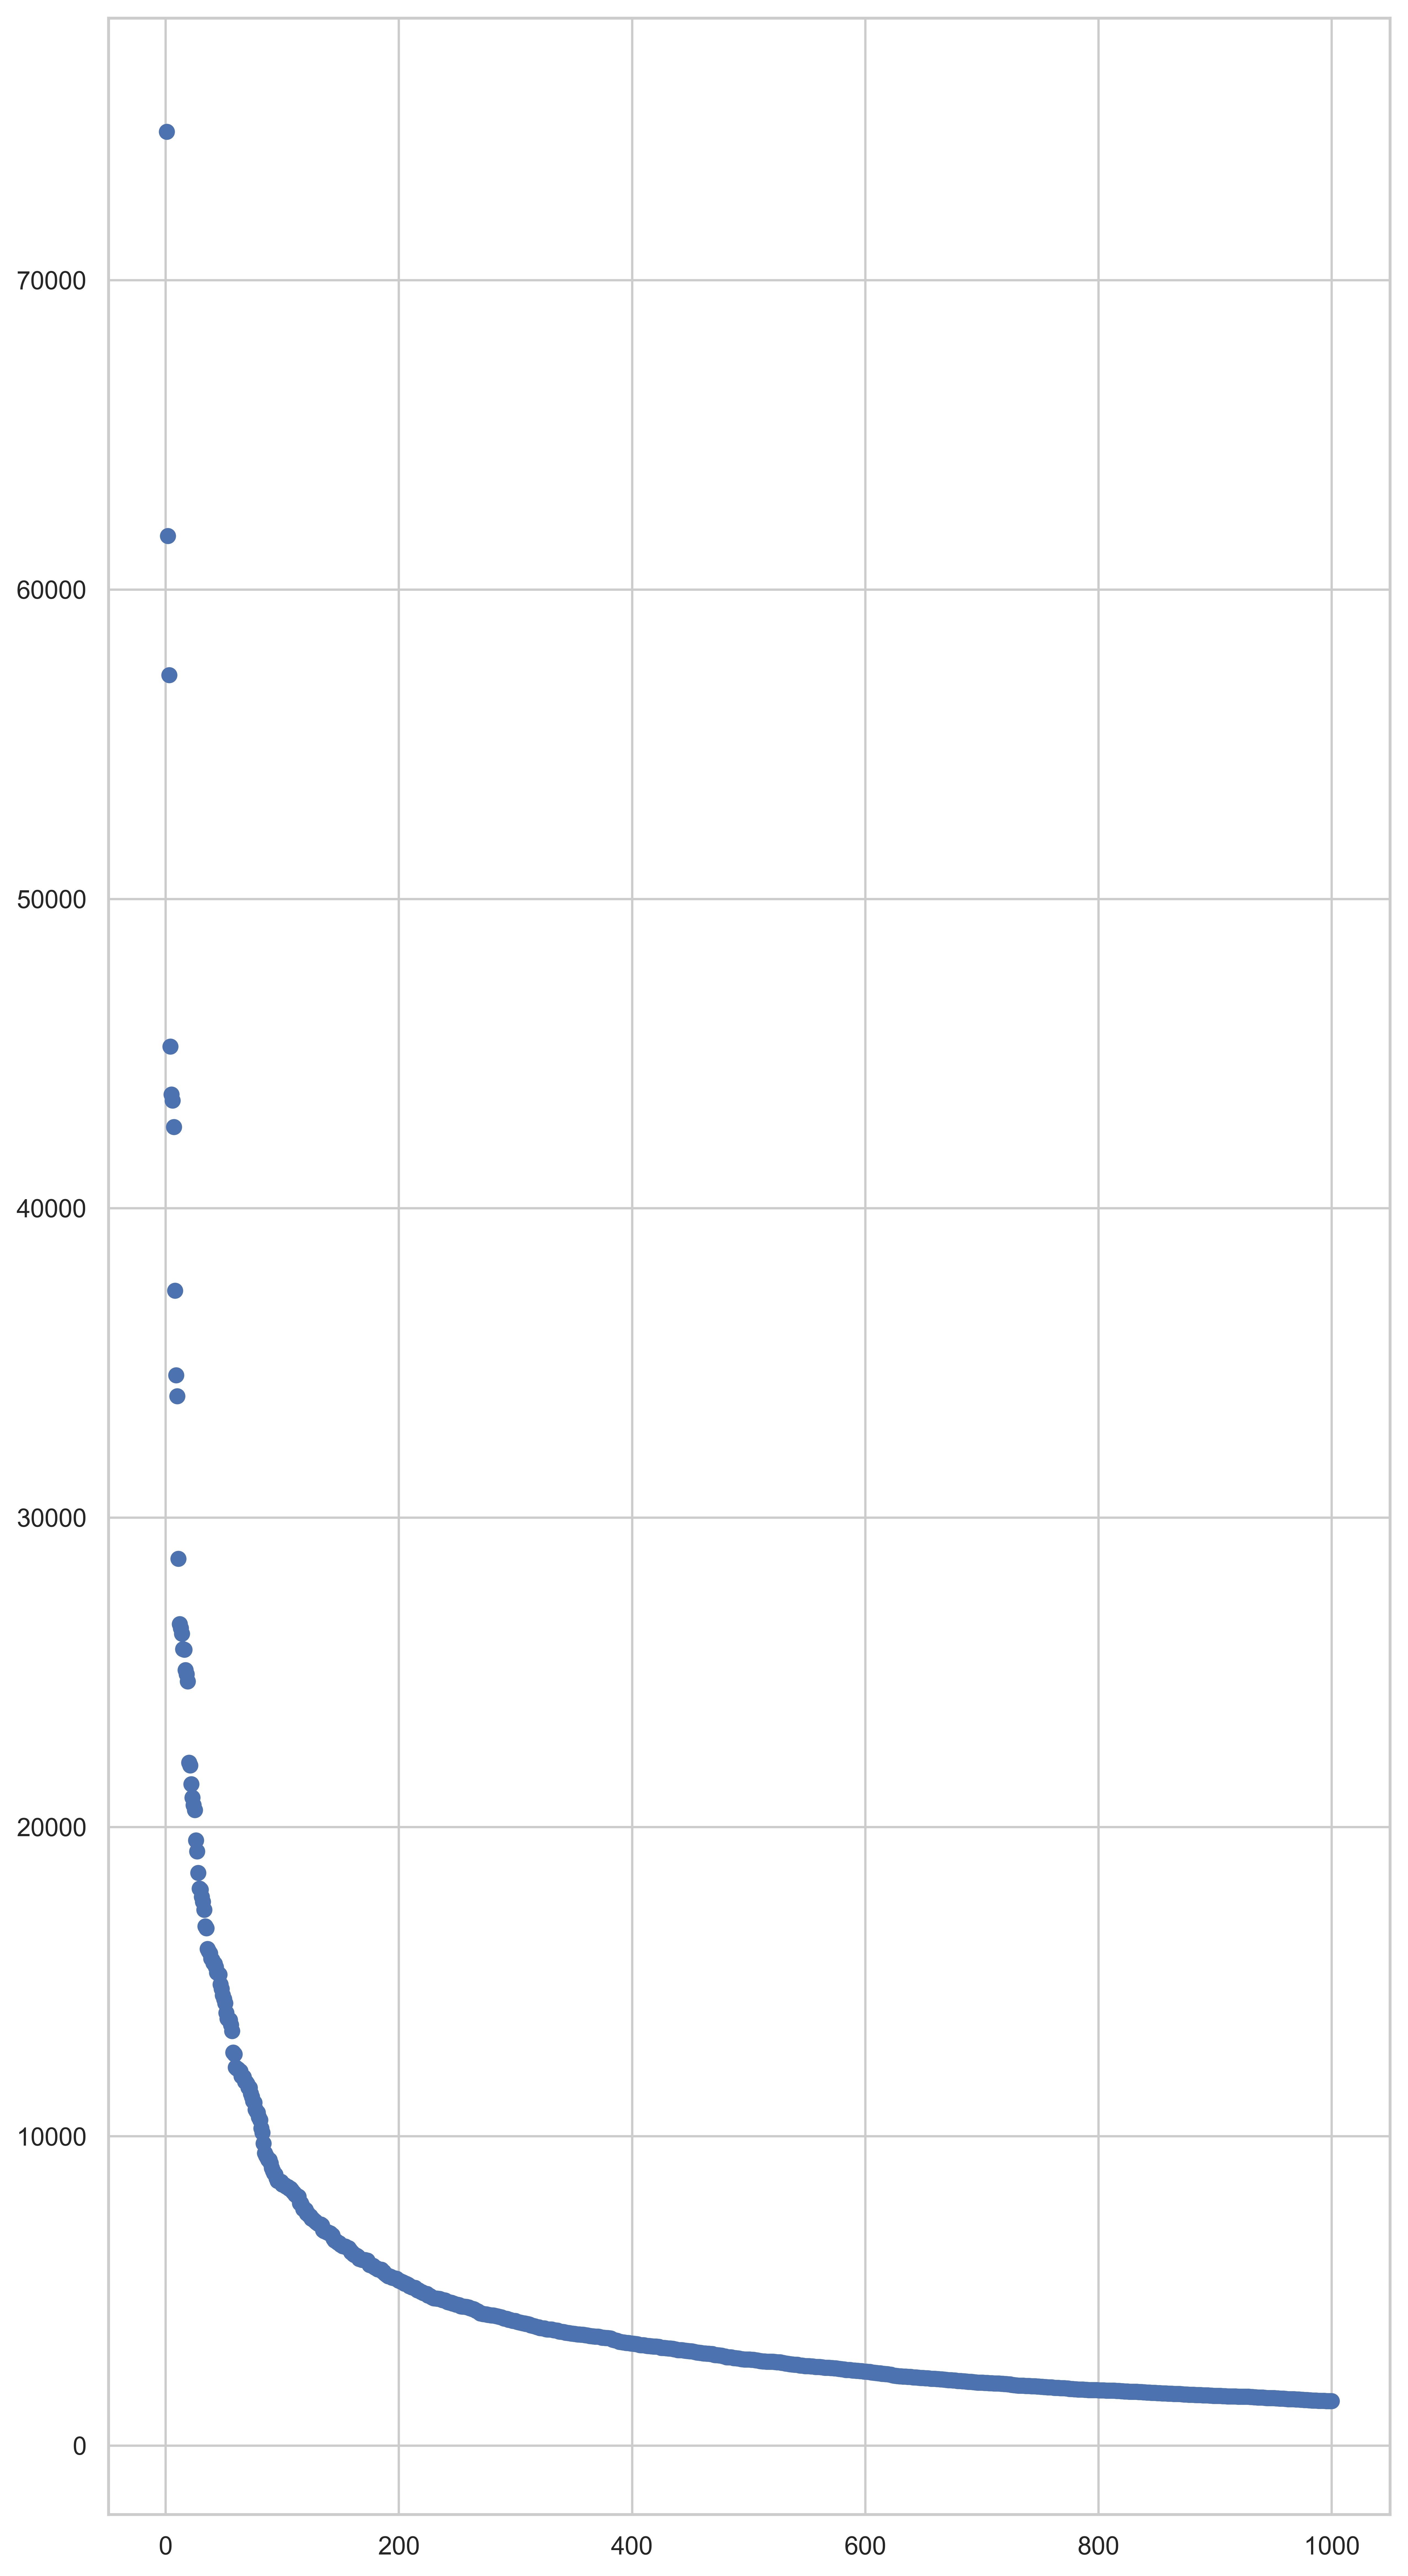

In [53]:
temp = target_0_1gram_df.wordcount.values[:1000]
plt.rcParams['figure.figsize'] = (10,20)
plt.scatter(x=range(1,1001), y=temp)

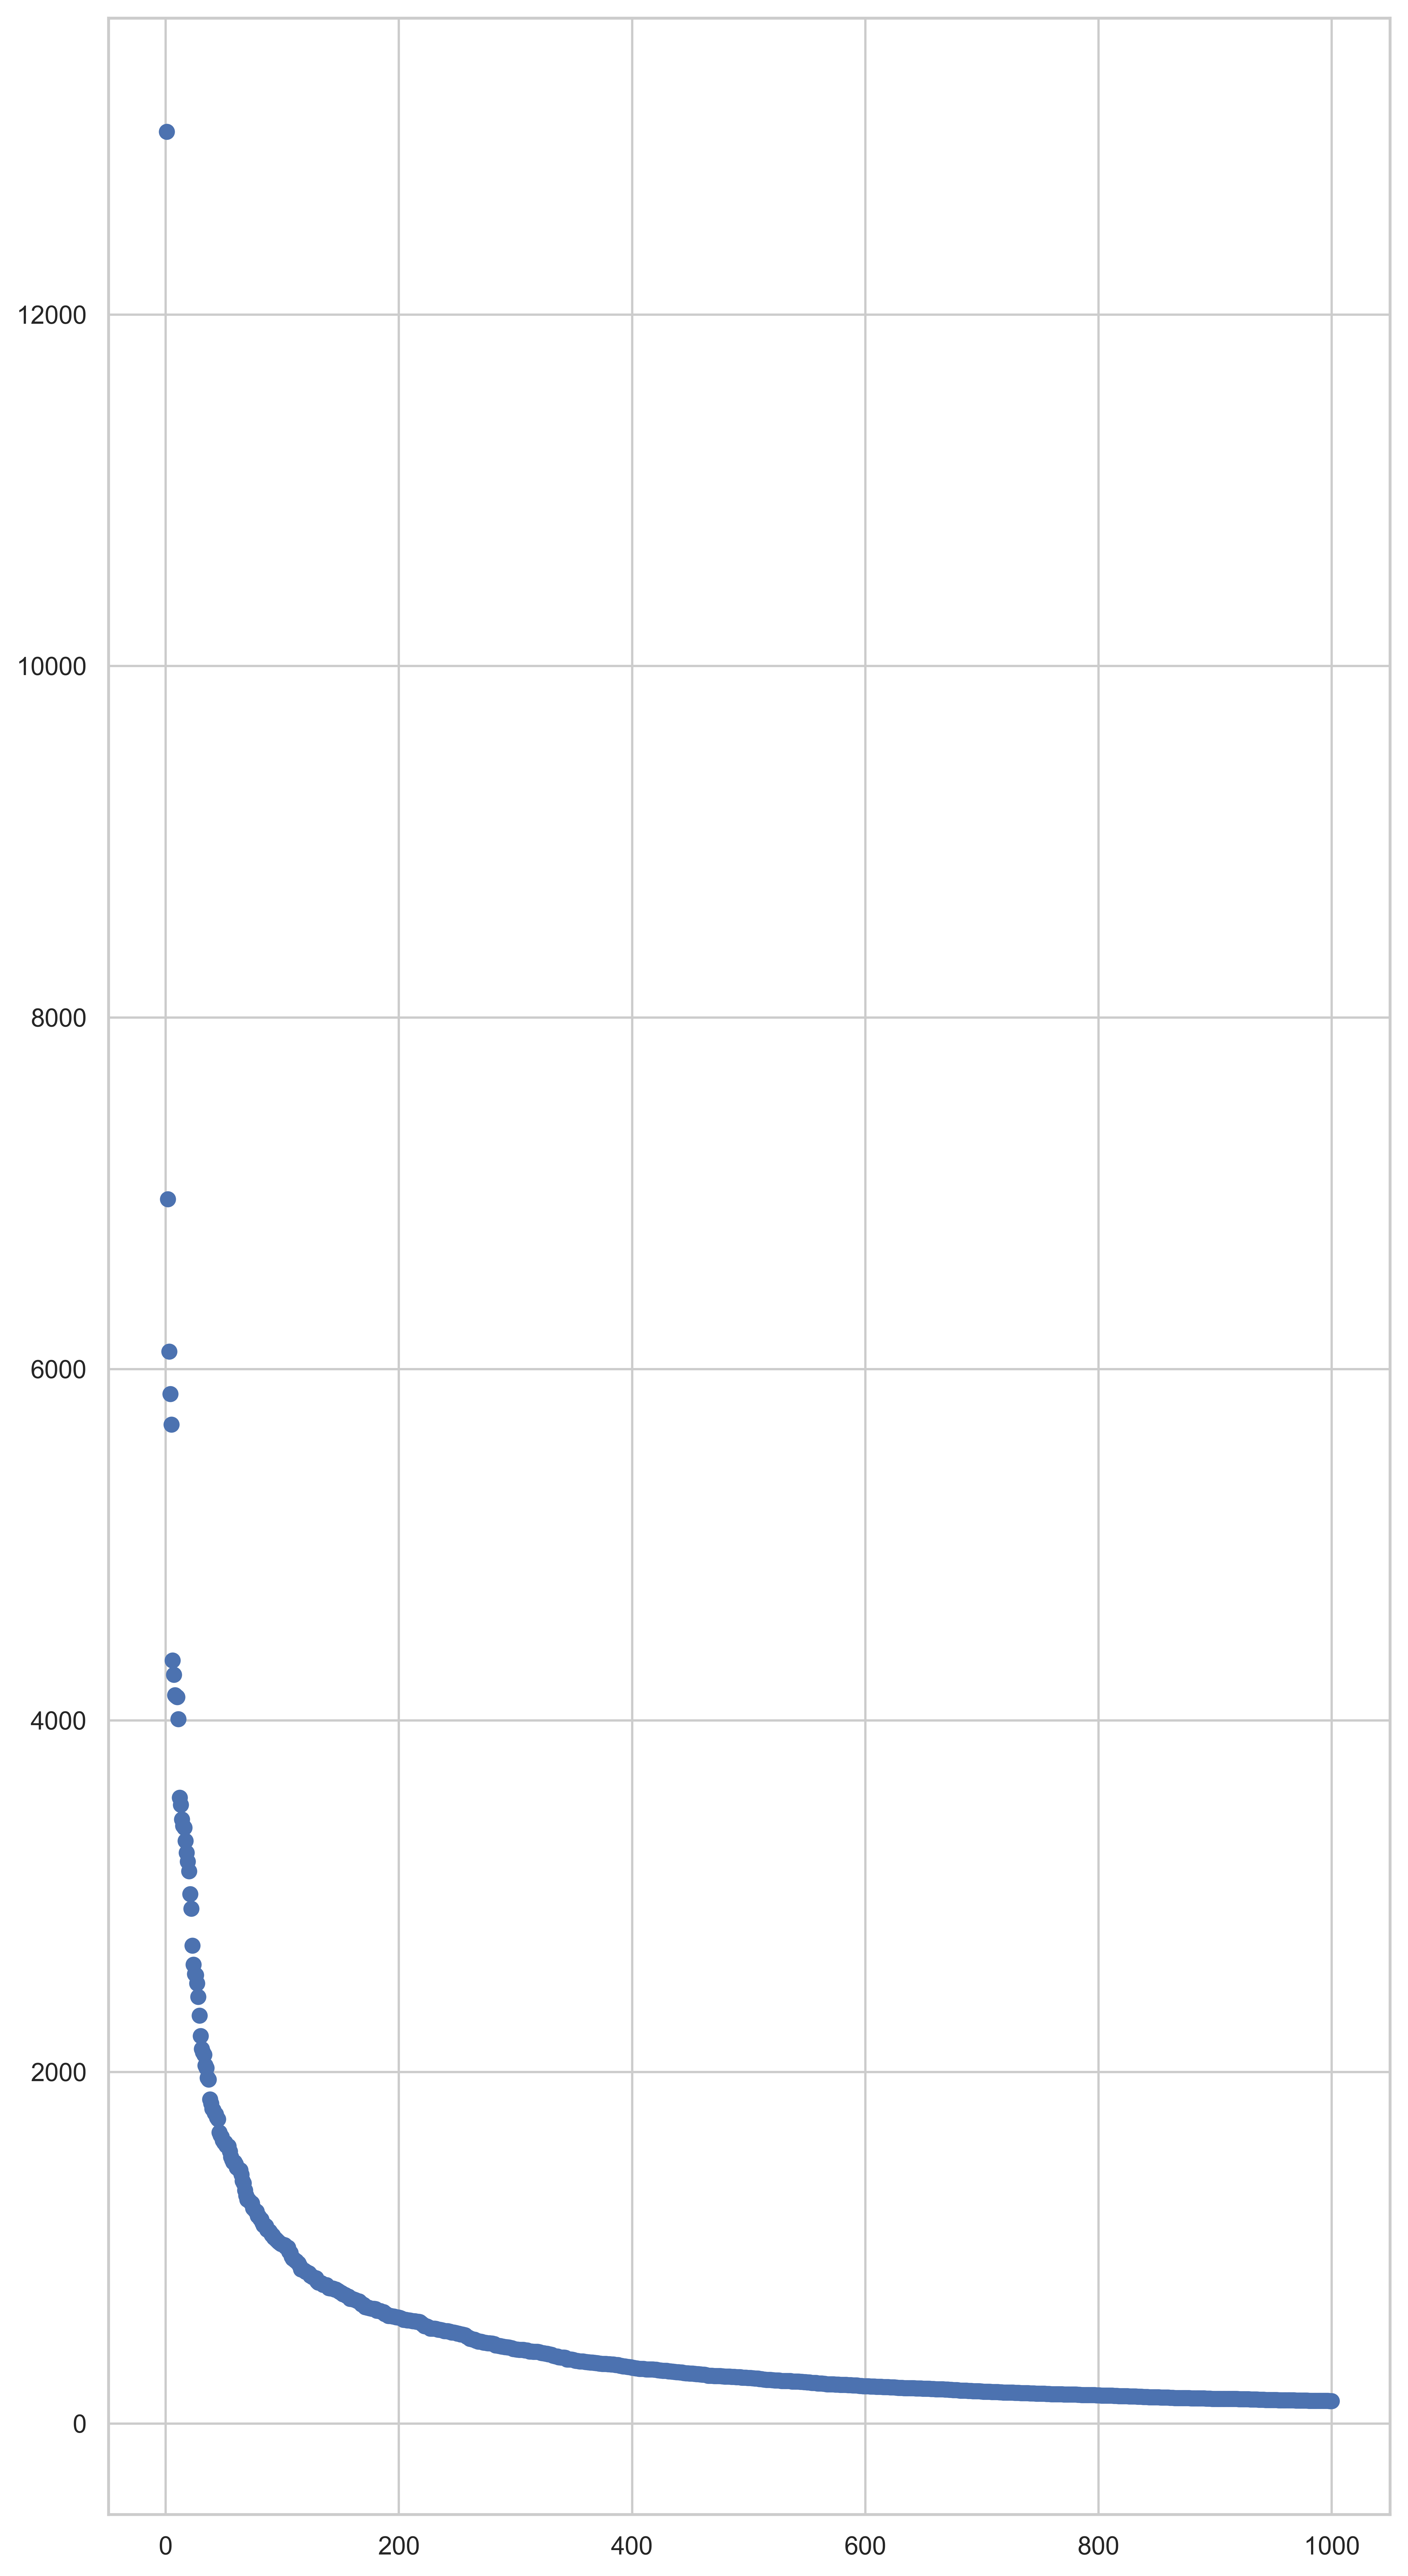

In [54]:
temp = target_1_1gram_df.wordcount.values[:1000]
plt.rcParams['figure.figsize'] = (10, 20)
plt.scatter(x=range(1,1001), y=temp)

In [55]:
target1_single_token = [word for word in target_1_1gram_df[:1000].word.values if word not in target_0_1gram_df[:600].word.values]

In [56]:
target1_bigram = [word for word in target_1_2gram_df[:1000].word.values if word not in target_0_2gram_df[:400].word.values]

In [57]:
vocab_list = list(set(target1_bigram + target1_single_token + list(target_0_1gram_df[:10000].word.values)))

In [58]:
len(vocab_list)

10860

In [59]:
model1 = Pipeline([
    ('vect', CountVectorizer(vocabulary=vocab_list, analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = 'english')),
    ('model', MultinomialNB()),
])

model2 = Pipeline([
    ('vect', CountVectorizer(vocabulary=vocab_list, analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = 'english')),
    ('model', LogisticRegression(C=1.0, class_weight='balanced', solver= 'liblinear')),
])

model3 = Pipeline([
    ('vect', TfidfVectorizer(vocabulary=vocab_list)),
    ('model', MultinomialNB()),
])

model4 = Pipeline([
    ('vect', TfidfVectorizer(vocabulary=vocab_list)),
    ('model', LogisticRegression(C=1.0, class_weight='balanced', solver= 'liblinear')),
])

#### Cross Validation score for each model

In [60]:
X = train_set.lemmatized
y = train_set.target

for i, model in enumerate([model1, model2, model3, model4]):
    scores = cross_val_score(model, X, y, cv=5, scoring="f1")
    print(("Model{0:d}: Mean score: {1:.3f}").format(i + 1, np.mean(scores)))

Model1: Mean score: 0.531
Model2: Mean score: 0.491
Model3: Mean score: 0.332
Model4: Mean score: 0.477


### tokenizer=CountVectorizer, model=MultinomialNB()

In [61]:
dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(
    train_set.lemmatized, train_set.target, test_size=0.3, random_state=0)

vect = CountVectorizer(vocabulary=vocab_list, analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = 'english')
vect.fit(train_set.lemmatized)
xtrain_vectorized =  vect.transform(dfX_train)
xtest_vectorized = vect.transform(dfX_test)

classifier = MultinomialNB().fit(X=xtrain_vectorized, y=dfy_train)
predictions = classifier.predict(xtest_vectorized)
print(classification_report(dfy_test, predictions, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.98      0.94      0.96    367621
     class 1       0.44      0.67      0.53     24176

   micro avg       0.93      0.93      0.93    391797
   macro avg       0.71      0.81      0.74    391797
weighted avg       0.94      0.93      0.93    391797



### 5.2. Logistic Regression 결과 improve 하기
- 1) parameter optimization
- 2) LogisticRegression 의 threshold 를 f1 score을 기준으로 조절

#### 1) parameter optimization

```
solver_options = ['saga', 'liblinear', 'sag']
class_weight_options = [None, 'balanced']

param_grid = {
    'solver': solver_options, 
    'class_weight' : class_weight_options,
    'C': [0.01, 0.1, 1, 10, 100], 
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

def find_optimal_param(refit_score='f1_score'):
    grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring=scorers, refit=refit_score, cv=3, return_train_score=True, n_jobs=5)
    grid_search.fit(xtrain_vectorized, dfy_train)

    y_pred = grid_search.predict(xtest_vectorized)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
```

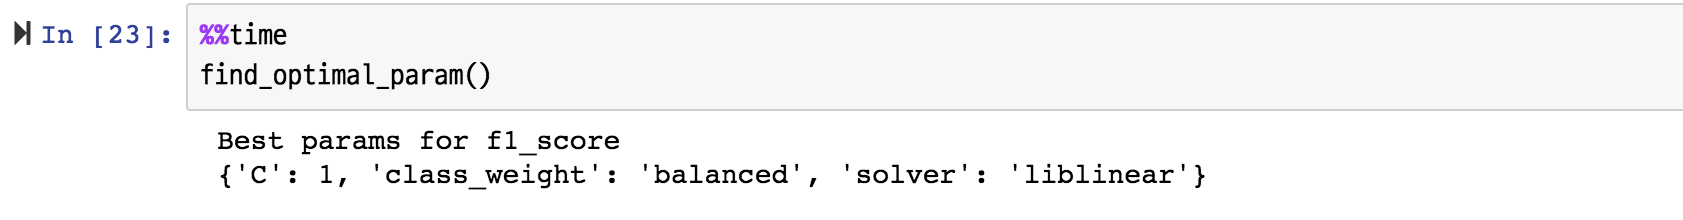

In [68]:
Image(filename = "./img/grid_search_param.png", width=800, height=800)

#### 2) LogisticRegression(parameter optimized) 의 threshold 를 f1 score을 기준으로 조절

In [69]:
dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(train_set.remove_string_special, train_set.target, test_size=0.2, random_state=5)

vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = 'english')
vectorizer.fit(train_set.remove_string_special)
xtrain_vectorized =  vectorizer.transform(dfX_train)
xtest_vectorized = vectorizer.transform(dfX_test)

model = LogisticRegression(C=1.0, class_weight='balanced').fit(X=xtrain_vectorized, y=dfy_train)
predictions = model.predict(xtest_vectorized)
print(classification_report(dfy_test, predictions, target_names=['class0', 'class1']))

              precision    recall  f1-score   support

      class0       0.98      0.96      0.97    244950
      class1       0.55      0.69      0.61     16248

   micro avg       0.95      0.95      0.95    261198
   macro avg       0.76      0.83      0.79    261198
weighted avg       0.95      0.95      0.95    261198



In [70]:
cross_val_score(model, vectorizer.transform(train_set.remove_string_special), train_set.target, cv=5, scoring="f1")

array([0.61145216, 0.61085677, 0.6149851 , 0.61444867, 0.61199705])

In [71]:
prediction_probs = model.predict_proba(xtest_vectorized)

x = np.linspace(0,1, num=25)

def new_predict(thresh):
    return [0 if (val<thresh) else 1 for val in prediction_probs[:,1]]

scores = [f1_score(dfy_test, new_predict(xx)) for xx in x]
data = [go.Scatter(x = x, y = scores)]
py.iplot(data, filename='basic-line')

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~isb6760/0 or inside your plot.ly account where it is named 'basic-line'


/usr/local/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [72]:
y_pred = new_predict(0.5833333)
print(classification_report(dfy_test, y_pred, target_names=['class0', 'class1']))

              precision    recall  f1-score   support

      class0       0.98      0.97      0.97    244950
      class1       0.58      0.65      0.61     16248

   micro avg       0.95      0.95      0.95    261198
   macro avg       0.78      0.81      0.79    261198
weighted avg       0.95      0.95      0.95    261198



- precision 이 오르고 recall 이 떨어져서 f1-score은 그대로 이다. 
- recall score 이 조금 더 중요하단 처음의 판단에 따라서 threshold=0.5로 계산된 위의 logistic regression model을 최종 모델로 채택하였다. 

# 6. Conclusion & Review